## Packages

In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import dcor
from statsmodels.graphics.tsaplots import plot_acf

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
import itertools

from sklearn.ensemble import IsolationForest

from matplotlib import patches

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
plt.rcParams.update({'font.size': 14})
plt.style.use('ggplot')

## Load Files

In [2]:
tb_number = 17
ftir_channel = 2

metadata_df = pd.concat([
    pd.read_pickle('TB17_metadata_df.pkl'),
], ignore_index=True)

# Load and merge TB17 and TB14 DataFrames
merged_influx_df = pd.concat([
    pd.read_pickle('TB17_merged_influx_df.pkl'),
], ignore_index=True)

stat_df = pd.concat([
    pd.read_pickle('TB17_stat_df.pkl'),
], ignore_index=True)

final_df = pd.concat([
    pd.read_pickle('TB17_final_df.pkl'),
], ignore_index=True)

# Load and merge dictionaries using update
merged_dict = {}
sensor_dict = {}
ftir_dict = {}
merged_dict = {}

with open(f'TB{tb_number}_merged_dict.pkl', 'rb') as file:
    merged_dict.update(pickle.load(file))
with open(f'TB{tb_number}_sensor_dict.pkl', 'rb') as file:
    sensor_dict.update(pickle.load(file))
with open(f'TB{tb_number}_merged_dict.pkl', 'rb') as file:
    merged_dict.update(pickle.load(file))

print("Merged data successfully saved.")

Merged data successfully saved.


# XGBoost

## Train Test Split

In [3]:
# Select relevant columns
merged_influx_df_XGBoost = merged_influx_df[['G2101(arc_voltage)',
                                             'G2101(arc_current)',
                                             'G2101(arc_power)',
                                             'FV2001(flow)',
                                             'FV2001(pressure)',
                                             'PT2201(pressure)',
                                             'EC_calc']]

# Drop NaN values in target
merged_influx_df_XGBoost_cleaned = merged_influx_df_XGBoost.dropna(subset=['EC_calc'])

# Define target and features
target = 'EC_calc'
X = merged_influx_df_XGBoost_cleaned.drop(columns=[target])
y = merged_influx_df_XGBoost_cleaned[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Data Cleansing

In [4]:
# Remove outliers using IQR
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
X_train_cleaned = X_train[~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)]
y_train_cleaned = y_train.loc[X_train_cleaned.index]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test)

# Remove highly correlated features
corr_matrix = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns).corr(method='kendall').abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
X_train_dedup = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns).drop(columns=highly_correlated_features)
X_test_dedup = pd.DataFrame(X_test_scaled, columns=X_test.columns).drop(columns=highly_correlated_features)

## XGBoost Setup

In [5]:
# Initialize and tune XGBoost with hyperparameter optimization
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0]
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_dedup, y_train_cleaned)
best_model = grid_search.best_estimator_

# Evaluate model
y_pred = best_model.predict(X_test_dedup)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Optimized RMSE: {rmse:.4f}")
print(f"Optimized R² Score: {r2:.4f}")

# Cross-validation
cv_scores = cross_val_score(best_model, X_train_dedup, y_train_cleaned, cv=5, scoring='r2')
print(f"Mean R² from Cross-Validation: {np.mean(cv_scores):.4f}")

C:\Users\Admin Henry Chen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Optimized RMSE: 0.4027
Optimized R² Score: 0.9876
Mean R² from Cross-Validation: 0.9907


## Visualization

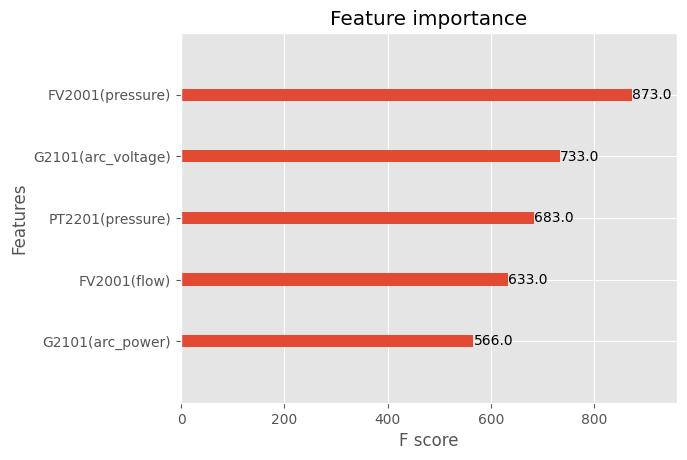

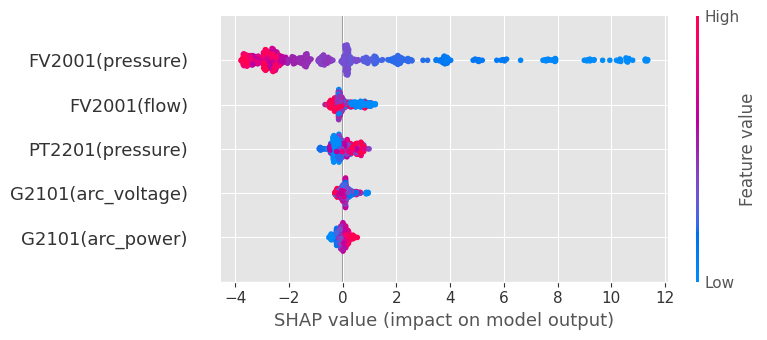

In [6]:
# Feature importance
xgb.plot_importance(best_model, importance_type='weight')
plt.show()

# SHAP analysis
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_dedup)
shap.summary_plot(shap_values, X_test_dedup)